In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

In [ ]:
def load_data(path):
    """ Helper function for loading a MAT-File"""
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('train_32x32.mat')
X_test, y_test = load_data('test_32x32.mat')

print("Training Set", X_train.shape, y_train.shape)
print("Test Set", X_test.shape, y_test.shape)

Training Set (32, 32, 3, 73257) (73257, 1)
Test Set (32, 32, 3, 26032) (26032, 1)


In [ ]:
# Transpose the image arrays
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

print("Training Set", X_train.shape)
print("Test Set", X_test.shape)
print('')

Training Set (73257, 32, 32, 3)
Test Set (26032, 32, 32, 3)



In [ ]:
# Calculate the total number of images
num_images = X_train.shape[0] + X_test.shape[0]

print("Total Number of Images", num_images)

#X_train = X_train[:,:,:,0]

#X_test = X_test[:,:,:,0]

Total Number of Images 89765


Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32)]          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 32, 128)           49664     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 50,954
Trainable params: 50,954
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
47/47 [==============================] - 21s 455ms/step - loss: 2.2365 - accuracy: 0.1958 - val_loss: 2.1993 - val_accuracy: 0.2094
Epoch 2/10
47/47 [==============================] - 21s 437ms/step - loss: 2.1813 - accuracy: 0.2209 - va

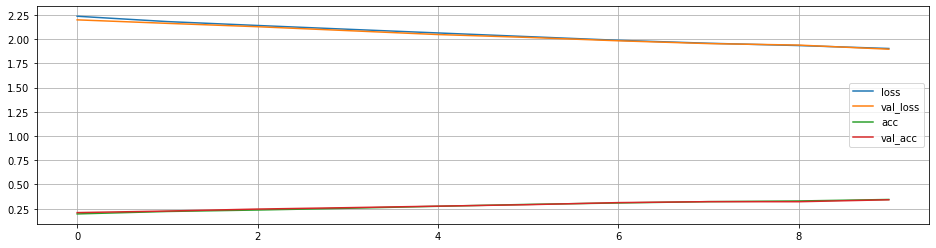

In [ ]:
#RNN model
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional, Lambda, Concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

D = 32
M = 64

input_ = Input(shape=(D, D))


# up-down
rnn1 = Bidirectional(LSTM(M, return_sequences=True))
x1 = rnn1(input_) # output is N x D x 2M
#x1 = Bidirectional(LSTM(M, return_sequences=True))(input_)

x1 = GlobalMaxPooling1D()(x1) # output is N x 2M

rnn2 = Bidirectional(LSTM(M, return_sequences=True))


# custom layer
permutor = Lambda(lambda t: K.permute_dimensions(t, pattern=(0, 2, 1)))
x2 = permutor(input_)
x2 = rnn2(x2) # output is N x D x 2M
x2 = GlobalMaxPooling1D()(x2) # output is N x 2M


# put them together
concatenator = Concatenate(axis=1)
x = concatenator([x1, x2]) # output is N x 4M


# final dense layer
output = Dense(10, activation='softmax')(x1)

model = Model(inputs=input_, outputs=output)

model.summary()

# compile
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)



# Fit the model
r = model.fit(X_train, y_train, batch_size=1024, epochs=10,  validation_split=0.25)


## Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.grid(True)
plt.legend()


# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.grid(True)
plt.legend()

print(model.evaluate(X_test, y_test))